In [1]:
6.2 / 1.73

3.5838150289017343

In [2]:
6.25/3.67

1.7029972752043596

#### Setup

In [2]:
# def 
def vp_KG(K, G, rho):
    return np.sqrt((K + 4./3*G) / rho)
def vs_KG(K, G, rho):
    return np.sqrt(G / rho)
def K_from_vels(vp, vs, rho):
    return rho*(vp**2 - 4/3*vs**2)
def G_from_vels(vs, rho):
    return rho * vs**2
def calc_bounds(ro1, K1, G1, ro2, K2, G2):
    from elasticc.limits import Reuss, Voigt, hs_bounds
    c2 = np.linspace(0,1,1000) # fluid fraction
    c1 = 1 - c2                # solid fraction
    Kr = Reuss(K1,c1,K2,c2)
    Gr = Reuss(G1,c1,G2,c2)
    Kv = Voigt(K1,c1,K2,c2)
    Gv = Voigt(G1,c1,G2,c2)
    Khs1, Ghs1 = hs_bounds(K1,K2,G1,G2,c1,c2)
    Khs2, Ghs2 = hs_bounds(K2,K1,G2,G1,c2,c1)
    K = dict(name='Bulk', v=Kv, r=Kr, hs1=Khs1, hs2=Khs2)
    G = dict(name='Shear', v=Gv, r=Gr, hs1=Ghs1, hs2=Ghs2)
    return c1, c2, K, G
def plot_bounds(ro1, K1, G1, ro2, K2, G2):
    c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    for i, M in enumerate([K,G]): 
        plt.subplot(121+i)
        plt.plot(c2,M['hs1'], label='H-S 1')
        plt.plot(c2,M['hs2'],label='H-S 2')
        plt.fill_between(c2, M['hs1'], M['hs2'], color='w')
        plt.xlabel('Melt fraction')
        plt.ylabel('%s modulus (GPa)' % M['name'])
        plt.xlim(0,1)
        plt.ylim(0,100)
        plt.grid()
        _ = plt.legend()     
def calc(vp_ref=6.2, vpvs=1.73, ro1=2.7, ro2=2.65, 
         a1=1, a2=0.1, K2=12.35, G2=1e-12 ):
    """
    Parameters
    ---------
    vp_ref : float
        In km/s. IMPORTANT
    ro : float
        Density. In g/cm3
    a : float
        Aspect ratio.
    K : float
        Bulk modulus. In GPa.
    G : float
        Shear modulus. In GPa.
    """
    # solid
    vs_ref = vp_ref / vpvs
    K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
    G1 =  G_from_vels(vs_ref, ro1)          # GPa 
    # H-S bounds
    c1, c2, K_hs, G_hs = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    roe = Voigt(ro1,c1,ro2,c2)
    vp_hs1 = vp_KG(K_hs['hs1'], G_hs['hs1'], roe)
    vp_hs2 = vp_KG(K_hs['hs2'], G_hs['hs2'], roe)
    # Relaxed, low frequency limit:
    # 1. Calculate dry moduli first (void fill)    
    a, b = vp_hs1, vp_hs2
    K_dry, G_dry = mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)
    # 2. Then use Gassman's fluid substitution
    K_lo, G_lo = gassman_2(K_dry,G_dry,K1,G1,K2,G2,c2) # NOTE
    vp_lo = vp_KG(K_lo, G_lo, roe)
    return a, b, c2, vp_lo

In [3]:
# load 
import numpy as np
import matplotlib.pyplot as plt
from arrau.a2d import Arr2d
from arrau.a3d import Arr3d
from elasticc.eep import mod_b, gassman_2
from elasticc.limits import Voigt
from fullwavepy.config.logging import *
from fullwavepy.plot.plt1d import colors
from fullwavepy.project.types.basic import ProjInv
from fullwavepy.seismic.misc import Box3d
from plotea.mpl2d import figure
plt.style.reload_library()
plt.style.use(['default', 'paper2022kolumbo'])
log_lvl(ERROR)
path = '/home/kmc3817/c_projects_phd/fwi_sant_kolumbo/'
geom = {'box': [8000.0, 25000.0, -3000.0, 15000.0, 0, 4000.0],
 'dt': 0.0025,
 'dx': 50,
 'ns': 2000}
p14 = ProjInv('p14', path=path, cat=0, **geom)
b01 = Box3d(8,25, -3,15, 0,4)
b02 = Box3d(8,18,  4,14, 0,4)
svp = Arr3d(p14.o.vp.it[0].read()/1e3, extent=b01.extent).extract(b02.extent)
vp_it = {}
for it in [160]:
    vp_it[it] = Arr3d(p14.o.vp.it[it].read()/1e3, extent=b01.extent).extract(b02.extent)

# V. 01

In [4]:
%%time 
step = 0.05
vals = np.arange(0.05, .5+step, step)
# vals = np.linspace(0.05, .2, 100)
hs1, hs2, vp = [], [], []
for i, a2 in enumerate(vals):
    a, b, c2, vp_lo = calc(a2=a2)
    hs1.append(a)
    hs2.append(b)
    vp.append(vp_lo)

/home/kmc3817/software/ElasticC/elasticc/eep.py:446: RuntimeWarning: overflow encountered in double_scalars
  A=Gi/G-1.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:447: RuntimeWarning: overflow encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:447: RuntimeWarning: invalid value encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:472: RuntimeWarning: overflow encountered in double_scalars
  A=Gi/G-1.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:473: RuntimeWarning: overflow encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:473: RuntimeWarning: invalid value encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:213: RuntimeWarning: invalid value encountered in double_scalars
  nu = 0.5*(3.0*Kd-2.0*Gd)/(3.0*Kd+Gd)
/home/kmc3817/software/ElasticC/elasticc/eep.py:195: RuntimeWarning: invalid val

CPU times: user 5.51 s, sys: 0 ns, total: 5.51 s
Wall time: 5.51 s


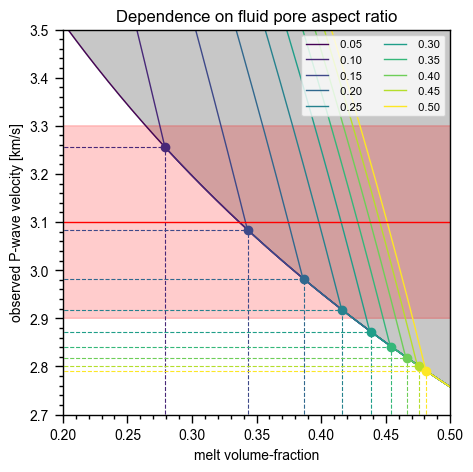

In [5]:
# plot 
extent = [[12,14],[7.75,9.75],[2,4]]
vp_min = np.min(vp_it[160].extract(extent).arr)
vp_fwi = 3.1 # vp_min # ~3.4 # km /s 
vp_err = 0.2 # km /s
xlim = [0,.5]
ylim = [2,6.2] # km/s
plt.style.reload_library()
plt.style.use(['default', 'paper2022kolumbo'])
figure(5,5)
title = 'Dependence on fluid pore aspect ratio'
cols = colors(len(vals),  cmap='viridis') # 'rainbow'
for i, a2 in enumerate(vals):
    color = next(cols)
    # calculate and plot critical-porosity points
    dif = np.nan_to_num(vp[i] - hs2[i])
    ## index where vp reaches H-S bound (= critical porosity)
    i_c = [i for i in np.where(np.abs(dif)<1e-3)[0] if i > 0 ][0]
    crit_fraction, crit_vp = c2[i_c], vp[i][i_c]
    plt.plot(crit_fraction, crit_vp, 'o', color=color)
    # plot helper-lines of these points
    x = np.linspace(0, crit_fraction, 100)
    y = np.linspace(0, crit_vp, len(x))
    crit_x = np.ones(len(x)) * crit_fraction
    crit_y = np.ones(len(y)) * crit_vp
    kws = dict(color=color, linewidth=0.8)
    plt.plot(crit_x, y, '--', **kws)
    plt.plot(x, crit_y, '--', **kws)
    # plot H-S bounds
    plt.fill_between(c2, hs1[i], hs2[i], color='Grey', alpha=.05)
    # plot SCS velocity
    plt.plot(c2, vp[i], color=color, label='%5.2f' % a2)
plt.fill_between(c2, np.ones(len(c2))*(vp_fwi-vp_err), np.ones(len(c2))*(vp_fwi+vp_err), 
                 color='r', alpha=.2)
# plt.plot(c2, np.ones(len(c2))*(vp_fwi-vp_err), 'k--')
# plt.plot(c2, np.ones(len(c2))*(vp_fwi+vp_err), 'k--')
# Y = np.linspace(*ylim, 20)
# plt.fill_betweenx(Y, np.ones(len(Y))*.25, np.ones(len(Y))*.5, color='Grey', alpha=.3)
plt.plot(c2, np.ones(len(c2))*(vp_fwi), color='red')
plt.xlabel('melt volume-fraction')
plt.ylabel('observed P-wave velocity [km/s]')
plt.xlim(.2,.5) #xlim)
plt.ylim(2.7,3.5)
# plt.ylim(ylim)
# plt.grid(c='k')
plt.title(title)   
_ = plt.legend(prop={'size': 8,}, loc='upper right', ncol=2)     

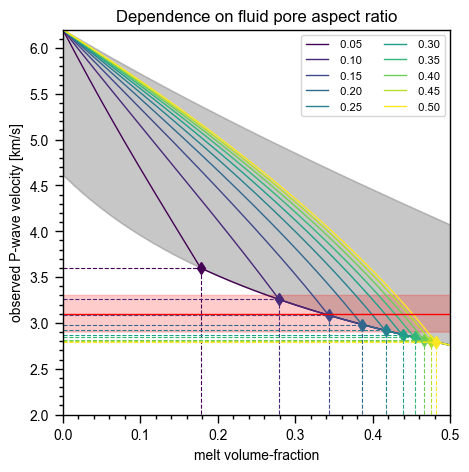

In [6]:
# plot 
extent = [[12,14],[7.75,9.75],[2,4]]
vp_min = np.min(vp_it[160].extract(extent).arr)
vp_fwi = 3.1 # vp_min # ~3.4 # km /s 
vp_err = 0.2 # km /s
xlim = [0,.5]
ylim = [2,6.2] # km/s
plt.style.reload_library()
plt.style.use(['default', 'paper2022kolumbo'])
figure(5,5)
title = 'Dependence on fluid pore aspect ratio'
cols = colors(len(vals),  cmap='viridis') # 'rainbow'
for i, a2 in enumerate(vals):
    color = next(cols)
    # calculate and plot critical-porosity points
    dif = np.nan_to_num(vp[i] - hs2[i])
    ## index where vp reaches H-S bound (= critical porosity)
    i_c = [i for i in np.where(np.abs(dif)<1e-3)[0] if i > 0 ][0]
    crit_fraction, crit_vp = c2[i_c], vp[i][i_c]
    plt.plot(crit_fraction, crit_vp, 'd', color=color)
    # plot helper-lines of these points
    x = np.linspace(0, crit_fraction, 100)
    y = np.linspace(0, crit_vp, len(x))
    crit_x = np.ones(len(x)) * crit_fraction
    crit_y = np.ones(len(y)) * crit_vp
    kws = dict(color=color, linewidth=0.8)
    plt.plot(crit_x, y, '--', **kws)
    plt.plot(x, crit_y, '--', **kws)
    # plot H-S bounds
    plt.fill_between(c2, hs1[i], hs2[i], color='Grey', alpha=.05)
    # plot SCS velocity
    plt.plot(c2, vp[i], color=color, label='%5.2f' % a2)
plt.fill_between(c2, np.ones(len(c2))*(vp_fwi-vp_err), np.ones(len(c2))*(vp_fwi+vp_err), 
                 color='r', alpha=.2)
# plt.plot(c2, np.ones(len(c2))*(vp_fwi-vp_err), 'k--')
# plt.plot(c2, np.ones(len(c2))*(vp_fwi+vp_err), 'k--')
# Y = np.linspace(*ylim, 20)
# plt.fill_betweenx(Y, np.ones(len(Y))*.25, np.ones(len(Y))*.5, color='Grey', alpha=.3)
plt.plot(c2, np.ones(len(c2))*(vp_fwi), color='red')
plt.xlabel('melt volume-fraction')
plt.ylabel('observed P-wave velocity [km/s]')
# plt.xlim(.2,.5) #xlim)
# plt.ylim(2.7,3.5)
plt.xlim(xlim)
plt.ylim(ylim)
# plt.grid(c='k')
plt.title(title)   
_ = plt.legend(prop={'size': 8,}, loc='upper right', ncol=2)     

# V. 02

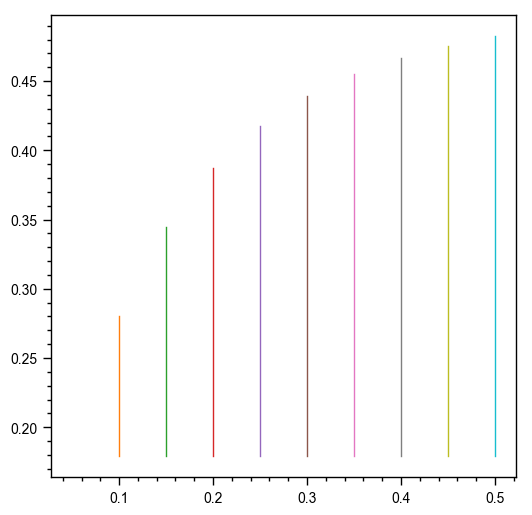

In [7]:
vp_crit, c_crit = [], []
for i, a2 in enumerate(vals):
    dif = np.nan_to_num(vp[i] - hs2[i])
    # index where vp reaches H-S bound (= critical porosity)
    i_c = [i for i in np.where(np.abs(dif)<1e-5)[0] if i > 0 ][0]
    vp_crit.append(vp[i][i_c])
    c_crit.append(c2[i_c])
    plt.errorbar(a2, c_crit)
# plt.plot(c_crit, vp_crit, '.')    


# V. 03

In [9]:
%%time 
step = 0.05
vals = np.arange(0.05, .5+step, step)
# vals = np.linspace(0.05, .2, 100)
hs1, hs2, vp = [], [], []
for i, a2 in enumerate(vals):
    a, b, c2, vp_lo = calc(a2=a2)
    hs1.append(a)
    hs2.append(b)
    vp.append(vp_lo)

CPU times: user 5.54 s, sys: 0 ns, total: 5.54 s
Wall time: 5.54 s


In [10]:
extent = [[12,14],[7.75,9.75],[2,4]]
vp_min = np.min(vp_it[160].extract(extent).arr)
vp_fwi = 3.1 # vp_min # ~3.4 # km /s 
vp_err = 0.2 # km /s
xlim = [0,.5]
ylim = [2,6.2] # km/s

In [12]:
figure(5,5)
def plot03(aspect_ratio_values, vp_values, hs2_values, 
           vp_fwi=3.1, vp_err=0.2, xlim=[0.,.5], ylim=[2.,6.2]):
    vals = aspect_ratio_values
    vp = vp_values
    hs2 = hs2_values
    #title = 'Dependence on fluid pore aspect ratio'
    cols = colors(len(vals),  cmap='viridis') # 'rainbow'
    for i, a2 in enumerate(vals):
        color = next(cols)
        # calculate and plot critical-porosity points
        dif = np.nan_to_num(vp[i] - hs2[i])
        ## index where vp reaches H-S bound (= critical porosity)
        i_c = [i for i in np.where(np.abs(dif)<1e-3)[0] if i > 0 ][0]
        crit_fraction, crit_vp = c2[i_c], vp[i][i_c]
        plt.plot(crit_fraction, crit_vp, 'o', color=color)
        # plot helper-lines of these points
        x = np.linspace(0, crit_fraction, 100)
        y = np.linspace(0, crit_vp, len(x))
        crit_x = np.ones(len(x)) * crit_fraction
        crit_y = np.ones(len(y)) * crit_vp
        kws = dict(color=color, linewidth=0.8)
        plt.plot(crit_x, y, '--', **kws)
        plt.plot(x, crit_y, '--', **kws)
        # plot H-S bounds
        plt.fill_between(c2, hs1[i], hs2[i], color='Grey', alpha=.05)
        # plot SCS velocity
        plt.plot(c2, vp[i], color=color, label='%5.2f' % a2)
    plt.fill_between(c2, np.ones(len(c2))*(vp_fwi-vp_err), np.ones(len(c2))*(vp_fwi+vp_err), 
                     color='r', alpha=.2)
    # plt.plot(c2, np.ones(len(c2))*(vp_fwi-vp_err), 'k--')
    # plt.plot(c2, np.ones(len(c2))*(vp_fwi+vp_err), 'k--')
    # Y = np.linspace(*ylim, 20)
    # plt.fill_betweenx(Y, np.ones(len(Y))*.25, np.ones(len(Y))*.5, color='Grey', alpha=.3)
    plt.plot(c2, np.ones(len(c2))*(vp_fwi), color='red')
    plt.xlabel('melt volume-fraction')
    plt.ylabel('observed P-wave velocity [km/s]')
    plt.xlim(.2,.5) #xlim)
    plt.ylim(2.7,3.5)
    # plt.ylim(ylim)
    # plt.grid(c='k')
    plt.title(title)   
    _ = plt.legend(prop={'size': 8,}, loc='upper right', ncol=2)         

<Figure size 500x500 with 0 Axes>

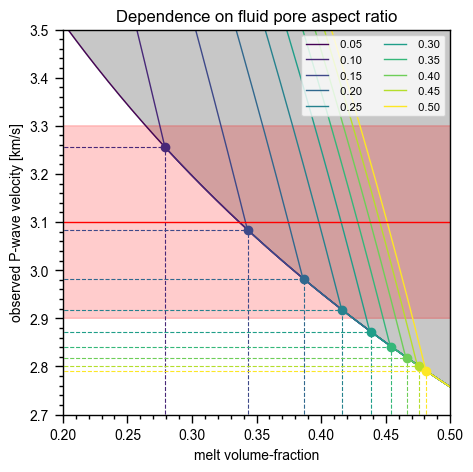

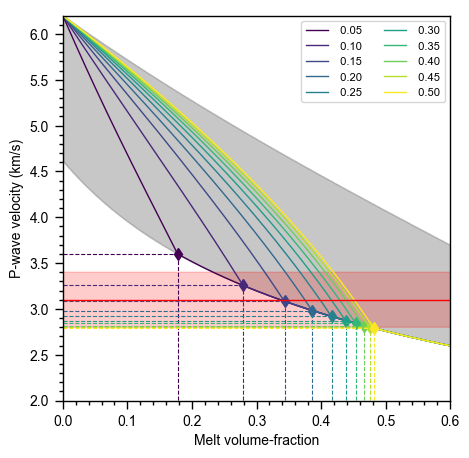

In [13]:
# plot 
extent = [[12,14],[7.75,9.75],[2,4]]
vp_min = np.min(vp_it[160].extract(extent).arr)
vp_fwi = 3.1 # vp_min # ~3.4 # km /s 
vp_err = 0.3 # km /s
xlim = [0,.6]
ylim = [2,6.2] # km/s
plt.style.reload_library()
plt.style.use(['default', 'paper2022kolumbo'])
figure(5,5)
title = 'Dependence on fluid pore aspect ratio'
cols = colors(len(vals),  cmap='viridis') # 'rainbow'
for i, a2 in enumerate(vals):
    color = next(cols)
    # calculate and plot critical-porosity points
    dif = np.nan_to_num(vp[i] - hs2[i])
    ## index where vp reaches H-S bound (= critical porosity)
    i_c = [i for i in np.where(np.abs(dif)<1e-3)[0] if i > 0 ][0]
    crit_fraction, crit_vp = c2[i_c], vp[i][i_c]
    plt.plot(crit_fraction, crit_vp, 'd', color=color)
    # plot helper-lines of these points
    x = np.linspace(0, crit_fraction, 100)
    y = np.linspace(0, crit_vp, len(x))
    crit_x = np.ones(len(x)) * crit_fraction
    crit_y = np.ones(len(y)) * crit_vp
    kws = dict(color=color, linewidth=0.8)
    plt.plot(crit_x, y, '--', **kws)
    plt.plot(x, crit_y, '--', **kws)
    # plot H-S bounds
    plt.fill_between(c2, hs1[i], hs2[i], color='Grey', alpha=.05)
    # plot SCS velocity
    plt.plot(c2, vp[i], color=color, label='%5.2f' % a2)
plt.fill_between(c2, np.ones(len(c2))*(vp_fwi-vp_err), np.ones(len(c2))*(vp_fwi+vp_err), 
                 color='r', alpha=.2)
# plt.plot(c2, np.ones(len(c2))*(vp_fwi-vp_err), 'k--')
# plt.plot(c2, np.ones(len(c2))*(vp_fwi+vp_err), 'k--')
# Y = np.linspace(*ylim, 20)
# plt.fill_betweenx(Y, np.ones(len(Y))*.25, np.ones(len(Y))*.5, color='Grey', alpha=.3)
plt.plot(c2, np.ones(len(c2))*(vp_fwi), color='red')
plt.xlabel('Melt volume-fraction')
plt.ylabel('P-wave velocity (km/s)')
# plt.xlim(.2,.5) #xlim)
# plt.ylim(2.7,3.5)
plt.xlim(xlim)
plt.ylim(ylim)
# plt.grid(c='k')
# plt.title(title)   
_ = plt.legend(prop={'size': 8,}, loc='upper right', ncol=2)    
plt.savefig('../manuscript/figures/fig03.png', dpi=300)    

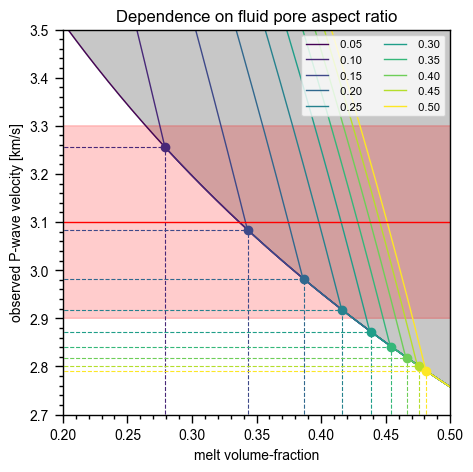

# V. 04
Account for the irregular distribution of critical points when calculating sigma.

In [14]:
%%time 
from scipy import interpolate
step = 0.05
vals = np.arange(0.05, 0.5+step, step)
# vals = np.linspace(0.05, .2, 100)
hs1, hs2, vp = [], [], []
vp2melt = []
for i, a2 in enumerate(vals):
    a, b, c2, vp_lo = calc(a2=a2)
    hs1.append(a)
    hs2.append(b)
    vp.append(vp_lo)
    vp2melt.append(interpolate.interp1d(vp_lo, c2))

/home/kmc3817/software/ElasticC/elasticc/eep.py:446: RuntimeWarning: overflow encountered in double_scalars
  A=Gi/G-1.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:447: RuntimeWarning: overflow encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:447: RuntimeWarning: invalid value encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:472: RuntimeWarning: overflow encountered in double_scalars
  A=Gi/G-1.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:473: RuntimeWarning: overflow encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:473: RuntimeWarning: invalid value encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:213: RuntimeWarning: invalid value encountered in double_scalars
  nu = 0.5*(3.0*Kd-2.0*Gd)/(3.0*Kd+Gd)
/home/kmc3817/software/ElasticC/elasticc/eep.py:195: RuntimeWarning: invalid val

CPU times: user 5.99 s, sys: 0 ns, total: 5.99 s
Wall time: 5.99 s


In [102]:
sigma = 0.1
print('For a=0.05 frac is in %s-%s' % (vp2melt[0](vp_fwi+sigma), vp2melt[0](vp_fwi-sigma)))
print('For a=0.5 frac is in %s-%s' % (vp2melt[-1](vp_fwi+sigma), vp2melt[-1](vp_fwi-sigma)))

For a=0.05 frac is in 0.3365927178299369-0.42475281411729443
For a=0.5 frac is in 0.4510791761960379-0.4708590506009043


In [100]:
# 3sigma!!!
print('For a=0.05 frac is in %s-%s' % (vp2melt[0](vp_fwi+vp_err), vp2melt[0](vp_fwi-vp_err)))
print('For a=0.5 frac is in %s-%s' % (vp2melt[-1](vp_fwi+vp_err), vp2melt[-1](vp_fwi-vp_err)))

For a=0.05 frac is in 0.26418995153824254-0.5336264307966928
For a=0.5 frac is in 0.43008542096230523-0.5336264312530117


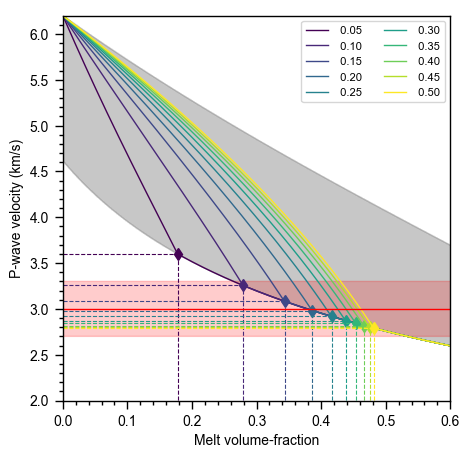

In [15]:
# plot 
extent = [[12,14],[7.75,9.75],[2,4]]
vp_min = np.min(vp_it[160].extract(extent).arr)
vp_fwi = 3.0 # 2.99... (see fig03b )
vp_err = 0.3 # km /s (3sigma from jackknife)
xlim = [0,.6]
ylim = [2,6.2] # km/s
plt.style.reload_library()
plt.style.use(['default', 'paper2022kolumbo'])
figure(5,5)
title = 'Dependence on fluid pore aspect ratio'
cols = colors(len(vals),  cmap='viridis') # 'rainbow'
for i, a2 in enumerate(vals):
    color = next(cols)
    # calculate and plot critical-porosity points
    dif = np.nan_to_num(vp[i] - hs2[i])
    ## index where vp reaches H-S bound (= critical porosity)
    i_c = [i for i in np.where(np.abs(dif)<1e-3)[0] if i > 0 ][0]
    crit_fraction, crit_vp = c2[i_c], vp[i][i_c]
    plt.plot(crit_fraction, crit_vp, 'd', color=color)
    # plot helper-lines of these points
    x = np.linspace(0, crit_fraction, 100)
    y = np.linspace(0, crit_vp, len(x))
    crit_x = np.ones(len(x)) * crit_fraction
    crit_y = np.ones(len(y)) * crit_vp
    kws = dict(color=color, linewidth=0.8)
    plt.plot(crit_x, y, '--', **kws)
    plt.plot(x, crit_y, '--', **kws)
    # plot H-S bounds
    plt.fill_between(c2, hs1[i], hs2[i], color='Grey', alpha=.05)
    # plot SCS velocity
    plt.plot(c2, vp[i], color=color, label='%5.2f' % a2)
plt.fill_between(c2, np.ones(len(c2))*(vp_fwi-vp_err), np.ones(len(c2))*(vp_fwi+vp_err), 
                 color='r', alpha=.2)
# plt.plot(c2, np.ones(len(c2))*(vp_fwi-vp_err), 'k--')
# plt.plot(c2, np.ones(len(c2))*(vp_fwi+vp_err), 'k--')
# Y = np.linspace(*ylim, 20)
# plt.fill_betweenx(Y, np.ones(len(Y))*.25, np.ones(len(Y))*.5, color='Grey', alpha=.3)
plt.plot(c2, np.ones(len(c2))*(vp_fwi), color='red')
plt.xlabel('Melt volume-fraction')
plt.ylabel('P-wave velocity (km/s)')
# plt.xlim(.2,.5) #xlim)
# plt.ylim(2.7,3.5)
plt.xlim(xlim)
plt.ylim(ylim)
# plt.grid(c='k')
# plt.title(title)   
_ = plt.legend(prop={'size': 8,}, loc='upper right', ncol=2)    
plt.savefig('../manuscript/figures/fig03.png', dpi=300)    

#### Alg.
Calculate mean and std across min. Vp at the centre of anomaly as a function of aspect ratio.

In [84]:
n = 1000
vp_gauss = np.random.normal(vp_fwi, vp_err/3, size=n) # cause vp_err was 3sigma

In [85]:
phis_all = []
phi_mean = []
phi_std = []
for i, a2 in enumerate(vals):
    phis = vp2melt[i](vp_gauss)
    phis_all += list(phis)
    phi_mean.append(np.mean(phis))
    phi_std.append(np.std(phis))

Text(0, 0.5, 'Melt fraction')

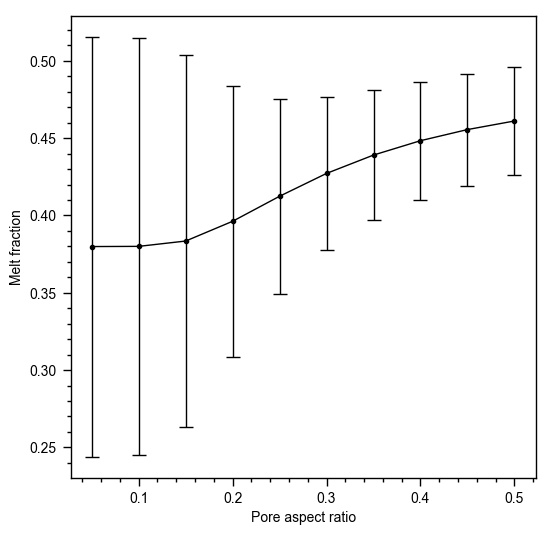

In [101]:
# plt.plot(vals, phi_mean, 'k.-')
plt.errorbar(vals, phi_mean, yerr=np.array(phi_std)*3, capsize=5, fmt='k.-')
plt.xlabel('Pore aspect ratio')
plt.ylabel('Melt fraction')

#### Alg.
Calculate mean and std across all free params.

In [71]:
np.mean(phis_all)

0.41846715091942316

In [72]:
np.std(phis_all)

0.04086898432937204

In [72]:
np.std(phis_all)

0.04086898432937204

In [67]:
phi_mean_all = np.mean(phi_mean)
phi_mean_all

0.41846715091942316

# ...